# 🤔 Using Rubrix for active learning with ModAL and scikit-learn.

In this tutorial, we will walk through the process of building an active learning prototype with Rubrix, the active learning framework [ModAL](https://modal-python.github.io/) and [scikit-learn](https://scikit-learn.org/)

## Introduction

**Our goal is to show you how to incorporate Rubrix into interactive workflows involving a human in the loop**. This is only a proof of concept for educational purposes and to inspire you with some ideas involving interactive learning processes. There are several great tools which focus on active learning, being [Prodi.gy](https://prodi.gy/) the most prominent.

### What is active learning?

[briefly describe]

### This tutorial

In this tutorial, we will build a simple text classifier by combining Rubrix, ModAL and scikit-learn.

The tutorial is organized into:

1. **...**: 

2. **...**

## Install ModAL and scikit-learn

In [15]:
!pip install pandas modAL scikit-learn matplotlib -qqq

## Setup Rubrix

[here we should point the user to the install and setup guide]

By default, rubrix will make a local initialization (as shown in the setup guide). If you want to specify an API url and key, you can pass that information via two environment variables: **RUBRIX_API_KEY** and **RUBRIX_API_URL**.

## Imports 

In [1]:
import rubrix as rb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.exceptions import NotFittedError
from modAL.models import ActiveLearner
import matplotlib.pyplot as plt

## 1. Loading and preparing data

Rubrix allows you to log and track data for different NLP tasks (such as `Token Classification` or `Text Classification`). 

In this tutorial, we will use the [YouTube Spam Collection](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/) dataset which is a binary classification task for detecting spam comments in youtube videos.

Let's load it in Pandas and take a look!

In [11]:
import pandas as pd
from urllib import request
from sklearn.model_selection import train_test_split
from pathlib import Path
from tempfile import TemporaryDirectory


def load_data() -> pd.DataFrame:
    links, data_df = [
        "http://lasid.sor.ufscar.br/labeling/datasets/9/download/",
        "http://lasid.sor.ufscar.br/labeling/datasets/10/download/",
        "http://lasid.sor.ufscar.br/labeling/datasets/11/download/",
        "http://lasid.sor.ufscar.br/labeling/datasets/12/download/",
        "http://lasid.sor.ufscar.br/labeling/datasets/13/download/",
    ], None
    
    with TemporaryDirectory() as tmpdirname:
        dfs = []
        for i, link in enumerate(links):
            file = Path(tmpdirname) / f"{i}.csv"
            request.urlretrieve(link, file)
            df = pd.read_csv(file)
            df["VIDEO"] = i
            dfs.append(df)
        data_df = pd.concat(dfs).reset_index(drop=True)
        
    train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
    
    return train_df, test_df

In [84]:
train_df, test_df = load_data()

In [86]:
train_df

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,VIDEO
836,z12sub0pnwzlgnz0r23pwvaqtuveyxr1z,Blaze Blaziken,2015-05-20T03:50:29.098000,you cant stop the shuffle﻿,0,2
1688,z12jdvqjrquct3bdj22yizigauehxj4ew,Lucia Scarlet,2015-05-22T11:56:53.104000,Amazing song﻿,0,4
1505,z12rdtlarmrzxhuba04cibjomsiqi3ij00g,Paul Buxton,2015-05-21T11:12:22.066000,Omg! This guy sounds like an american professo...,0,3
1650,z13it35hwti1uf0ea22ju5dxoyqiubdso,Tierra Carbon,2015-05-24T14:21:54.411000,It was cool the best song ever ﻿,0,4
1573,LneaDw26bFvJWycbUHAiKy7i7L14RqXWenvvcJhwbQE,David Bottenberg,NaN,subscribe to my channel /watch?v=NxK32i0HkDs,1,3
...,...,...,...,...,...,...
1130,z121szzyozr4vpqqc04cdn5g4zjhutdosdw,ItsJoey Dash,2014-07-22T10:04:05.755000,EVERYONE PLEASE SUBSCRIBE TO MY CHANNEL OR CAN...,1,2
1294,LneaDw26bFvtmJorLbUQjuqmpL7TdjOKPGJT_DGUUJ4,louis canellony,NaN,watch youtube video &quot;EMINEM -YTMA artist ...,1,3
860,z13cfr5o3mnyez4ju04ce3whmvflg1fifl00k,vieshva .d.exodous,2015-05-18T08:38:34.236000,Awesome﻿,0,2
1459,z12rhdkrvvy3hd42c23whdeavkjdxnimg,viviane trinh,2015-05-21T22:35:35.753000,i like the lyrics but not to music video﻿,0,3


# Make NGRAMs

*TODO: A short explanation of CountVectorizer and what we are doing here*

In [87]:
vectorizer = CountVectorizer(ngram_range=(1, 5))

X_train = vectorizer.fit_transform(train_df.CONTENT)
X_test = vectorizer.transform(test_df.CONTENT)

# 2. Defining our classifier and Active Learner

In [88]:
# Define our classification model

classifier = MultinomialNB()

# Acutally the LogisticRegression model works slightly better
#from sklearn.linear_model import LogisticRegression
#classifier = LogisticRegression(C=1e3, solver="liblinear")

In [89]:
# # This is the maximum value we can score: 0.9235
# classifier.fit(X=X_train, y=train_df.CLASS)
# classifier.score(X=X_test, y=test_df.CLASS)

In [90]:
# Define active learner

learner = ActiveLearner(
    estimator=classifier,
)

## 3. Active Learning loop

Active learning consists of several iteration steps:
1. Annotate samples
2. Teach the active learner

In [133]:
# Number of instances we want to annotate per iteration
n_instances = 10

# Accuracies after each iteration to keep track of our improvement
accuracies = []

### 1. Annotate samples

In [ ]:
# query examples from our training pool with the most uncertain prediction
query_idx, query_inst = learner.query(X_train, n_instances=n_instances)

# get predictions for the queried examples
try:
    probs = learner.predict_proba(X_train[query_idx])
# For the very first query we do not have any predictions
except NotFittedError:
    probs = [[0.5, 0.5]]*n_instances

# Build the Rubrix records
records = [
    rb.TextClassificationRecord(
        id=idx,
        inputs={"text": train_df.CONTENT.iloc[idx]},
        prediction=list(zip(["HAM", "SPAM"], [0.5, 0.5])),
        prediction_agent="MultinomialNB",
    )
    for idx in query_idx
]

# Log the records
rb.log(records, name="active_learning_tutorial")

### 2. Teach the learner

In [ ]:
# Load the annotated records into a pandas DataFrame
records_df = rb.load("active_learning_tutorial")

# filter examples from the last annotation session
idx = df.id.isin(query_idx)

# check if all examples were annotated
if any(df[idx].annotation.isna()):
    print("ERROR: Please annotate first all your samples before teaching the model")
# train the classifier with the newly annotated examples
else:
    y_train = df[idx].annotation.map(lambda x: int(x[0] == "SPAM"))
    learner.teach(X=X_train[query_idx], y=y_train.to_list())
    
# Keep track of our improvement
accuracies.append(learner.score(X=X_test, y=test_df.CLASS))

### Plot our improvement

Text(0, 0.5, 'Accuracy')

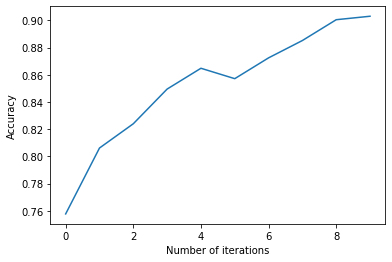

In [152]:
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")

## Appendix: Compare query strategies, random vs max uncertainty

In [129]:
n_iterations = 150
n_instances = 10
random_samples = 50


# max uncertainty strategy
accuracies_max = []
for i in range(random_samples):
    train_rnd_df = train_df.sample(frac=1)
    test_rnd_df = test_df.sample(frac=1)
    X_rnd_train = vectorizer.transform(train_rnd_df.CONTENT)
    X_rnd_test = vectorizer.transform(test_rnd_df.CONTENT)
    
    accuracies, learner = [], ActiveLearner(estimator=MultinomialNB())

    for i in range(n_iterations):
        query_idx, _ = learner.query(X_rnd_train, n_instances=n_instances)
        learner.teach(X=X_rnd_train[query_idx], y=train_rnd_df.CLASS.iloc[query_idx].to_list())
        accuracies.append(learner.score(X=X_rnd_test, y=test_rnd_df.CLASS))
    accuracies_max.append(accuracies)

# random strategy
accuracies_rnd = []
for i in range(random_samples):
    accuracies, learner = [], ActiveLearner(estimator=MultinomialNB())
    
    for random_idx in np.random.choice(X_train.shape[0], size=(n_iterations, n_instances), replace=False):    
        learner.teach(X=X_train[random_idx], y=train_df.CLASS.iloc[random_idx].to_list())
        accuracies.append(learner.score(X=X_test, y=test_df.CLASS))
    accuracies_rnd.append(accuracies)
    
arr_max, arr_rnd = np.array(accuracies_max), np.array(accuracies_rnd)

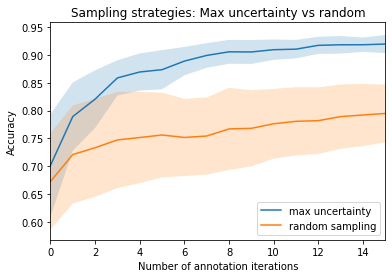

In [141]:
plt.plot(range(n_iterations), arr_max.mean(0))
plt.fill_between(range(n_iterations), arr_max.mean(0)-arr_max.std(0), arr_max.mean(0)+arr_max.std(0), alpha=0.2)
plt.plot(range(n_iterations), arr_rnd.mean(0))
plt.fill_between(range(n_iterations), arr_rnd.mean(0)-arr_rnd.std(0), arr_rnd.mean(0)+arr_rnd.std(0), alpha=0.2)
      
plt.xlim(0,15)
plt.title("Sampling strategies: Max uncertainty vs random")
plt.xlabel("Number of annotation iterations")
plt.ylabel("Accuracy")
plt.legend(["max uncertainty", "random sampling"], loc=4)

## Summary

## Next steps